$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x)= p_{\sigma_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ <br>

In [42]:
import numpy as np
import random

force = .5
actions = np.array([(force,0), (-force,0), (0,force), (0,-force)])
theta = [5, (.005,.3)]

def mu(s, a, p=2):
    acts = actions[a]
    return s + acts + np.random.normal(0, p, 2)

def beta(x,y):
    psi, _ = theta
    return 1*((x**2 + y**2)**(1/2) < psi)

def generate(s0, n):   
    _, sigma = theta
    s = s0
    for _ in range(n):
        a = np.random.choice(4, 1)[0]
        m = beta(s[:,0], s[:,1])[0]
        sa = np.insert(s, s.size, a)
        yield np.insert(sa, sa.size, m)
        s = mu(s, a, sigma[m])

# def trajectory(s_0=(1,1), n=100):
#     gen = generate(s_0, n)
#     return np.fromiter(gen, dtype=np.dtype((float, 4)))

# s_0 = np.array([[0,0]])
# n = 1000

# O = trajectory(s_0, n)
# O[:] # all
# O[:,0:2] # states
# O[:,2] # actions
# O[:,3] # hidden models


In [43]:
import pandas as pd

def generate_data(trajectory_size=1000, n_trajectories=10, s_0=(0,0)):
    s_0 = np.array([s_0])
    gen = generate(s_0, 1)
    sx,sy,a,m = next(gen)
    df = pd.DataFrame({
        'n':[0],
        't':[0],
        's':[(sx,sy)],
        'a':[int(a)],
        'm':[int(m)]
        })

    for i in range(n_trajectories):
        gen = generate(s_0, trajectory_size)
        for t,(sx,sy,a,m) in enumerate(gen):
            df.loc[len(df.index)] = [int(i),int(t),(sx,sy),int(a),int(m)]

    df.drop(0, inplace=True)
    return df

df = generate_data() 
df.head()

,n,t,s,a,m
1,0,0,"(0, 0)",1,1
2,0,1,"(-0.4488627873376431, 0.008569169204320385)",1,1
3,0,2,"(-1.2751741354429627, -0.5094059833713585)",0,1
4,0,3,"(-0.3222302277083809, -0.3795397109841313)",1,1
5,0,4,"(-0.3633919691167856, -0.9751056311448507)",1,1


<AxesSubplot: >

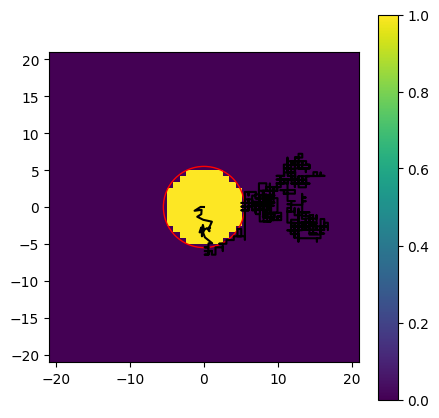

In [44]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_trajectory(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    # ax.invert_yaxis()

    size = 20
    res = 50
    x = np.linspace(-size, size, res).reshape(-1,1)
    y = np.linspace(-size, size, res).reshape(-1,1)

    X,Y = np.meshgrid(x,y)
    p = ax.imshow(beta(X,Y), extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1), vmin = 0, vmax = 1)
    plt.colorbar(p)
    ax.invert_yaxis()

    df_s = pd.DataFrame(data.s.to_list(), columns=['x','y'])
    ax.plot(df_s.x, df_s.y, color='black')
    ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))
    return ax

plot_trajectory(df[df.n==0])

In [45]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

class BetaModel(nn.Module):
    def __init__(self):
        super(BetaModel, self).__init__()
        n_features = 2
        n_models = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden).double(),
            # nn.ReLU(),
            nn.Linear(n_hidden, n_models).double(),
            nn.ReLU(),
            nn.Softmax(dim=1)
            # nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)
    
class SigmaModel(nn.Module):
    def __init__(self):
        super(SigmaModel, self).__init__()
        n_features = 5
        n_models = 1

        self.model = nn.Sequential(
            nn.Linear(n_features, n_models).double(),
            # nn.ReLU(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)

In [46]:
import functools

def loglike(beta, mi, data):
    p_theta = torch.sum((mi * beta), 1) 
    return -torch.sum(torch.log(p_theta))


# df_teste = df.loc[df.n==0].iloc[:-1].copy()
# df_teste['m2'] = 1-df_teste.m
# loglike(torch.from_numpy(df_teste[['m2', 'm']].to_numpy()), df.loc[df.n==0])


In [51]:

def train(beta_model, sigma_models, data, epochs=1000, log=False):
    x_train_tensor_beta = torch.tensor(data['s'].iloc[:-1].apply(pd.Series).to_numpy()).type(torch.DoubleTensor)
    x_train_tensor_sigma = torch.tensor(pd.concat([
        data['s'].iloc[:-1].apply(pd.Series).reset_index().drop(columns=['index']), 
        data.a.iloc[:-1].reset_index().drop(columns=['index']), 
        data['s'].iloc[1:].apply(pd.Series).reset_index().drop(columns=['index'])
    ], axis=1).to_numpy()).type(torch.DoubleTensor)

    to_opt = [{'params': beta_model.parameters()}] + [{'params': sigma.parameters()} for sigma in sigma_models]
    optim = torch.optim.SGD(to_opt, lr=1e-4, momentum=.9)
    loss = loglike

    def do_train(epoch):
        optim.zero_grad()
        beta_value = beta_model(x_train_tensor_beta)
        mu_value = torch.stack([torch.reshape(sigma(x_train_tensor_sigma), (-1,)) for sigma in sigma_models], dim=1)

        ll = loss(beta_value, mu_value, data)
        if log:
            print(epoch, ll.item())
        ll.backward()
        optim.step() 
        return ll.item()

    beta_model.train(True)
    for sigma in sigma_models:
        sigma.train(True)
    lls = [do_train(epoch) for epoch in range(epochs)]
    beta_model.train(False)
    for sigma in sigma_models:
        sigma.train(False)

    return lls


torch.manual_seed(0)
log = True
def train_models(data, n_models=10):
    models = [(BetaModel(), [SigmaModel(), SigmaModel()]) for _ in range(n_models)]
    results = [train(*model, data, epochs=1000, log=log) for model in models]
    return models, results

mod, res = train_models(df[df.n==0], 1)
res

0 1177.9128007654217
1 51.136051984247544
2 21.277845966392974
3 19.471874838136
4 18.39001797157845
5 17.399272248426968
6 16.471914567119114
7 15.646722991588458
8 15.209603948610301
9 14.926653575499444
10 14.685009241137903
11 14.475470089693236
12 14.28068045956278
13 14.097804074514752
14 13.924981517022843
15 13.760607492322123
16 13.603326671712178
17 13.452015475320332
18 13.307275944548465
19 13.167173423499833
20 13.03067181357107
21 12.89730862783607
22 12.766728195257652
23 12.638659946427245
24 12.512890321825903
25 12.389266828944129
26 12.267676874169878
27 12.148036095461359
28 12.0302837497769
29 11.9143765750054
30 11.80028389708613
31 11.687983770897121
32 11.577459973322792
33 11.46869969378131
34 11.361691791327326
35 11.256425508350468
36 11.152889549056997
37 11.05107144658028
38 10.950957155960653
39 10.852530821617048
40 10.755774677533639
41 10.660669046437487
42 10.567192410951696
43 10.475321535266007
44 10.385031620441724
45 10.296296480212947
46 10.209088

[[1177.9128007654217,
  51.136051984247544,
  21.277845966392974,
  19.471874838136,
  18.39001797157845,
  17.399272248426968,
  16.471914567119114,
  15.646722991588458,
  15.209603948610301,
  14.926653575499444,
  14.685009241137903,
  14.475470089693236,
  14.28068045956278,
  14.097804074514752,
  13.924981517022843,
  13.760607492322123,
  13.603326671712178,
  13.452015475320332,
  13.307275944548465,
  13.167173423499833,
  13.03067181357107,
  12.89730862783607,
  12.766728195257652,
  12.638659946427245,
  12.512890321825903,
  12.389266828944129,
  12.267676874169878,
  12.148036095461359,
  12.0302837497769,
  11.9143765750054,
  11.80028389708613,
  11.687983770897121,
  11.577459973322792,
  11.46869969378131,
  11.361691791327326,
  11.256425508350468,
  11.152889549056997,
  11.05107144658028,
  10.950957155960653,
  10.852530821617048,
  10.755774677533639,
  10.660669046437487,
  10.567192410951696,
  10.475321535266007,
  10.385031620441724,
  10.296296480212947,
  

In [68]:
from scipy.stats import norm

x,y = 0,0
a = 1 
x_,y_ = 1,0

print('sigma_1: ', norm.pdf(x_, (x + actions[a][0]), theta[1][0]) * norm.pdf(y_, (y + actions[a][1]), theta[1][0]))
print('sigma_2: ', norm.pdf(x_, (x + actions[a][0]), theta[1][1]) * norm.pdf(y_, (y + actions[a][1]), theta[1][1]))


inp = torch.tensor([[x,y, a, x_,y_]]).type(torch.DoubleTensor)

print("m_1: ", mod[0][1][0](inp))
print("m_2: ", mod[0][1][1](inp))

sigma_1:  0.0
sigma_2:  6.5901697058379135e-06
m_1:  tensor([[0.9951]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)
m_2:  tensor([[0.9923]], dtype=torch.float64, grad_fn=<SigmoidBackward0>)


In [25]:
def train_models(data, n_models=10):
    models = [(BetaModel(), [SigmaModel(), SigmaModel()]) for _ in range(n_models)]
    results = [train(*model, data) for model in models]
    return models, results

n = 10 
m = 5
models = []
results = []
for i in range(n):
    mod, res = train_models(df[df.n==i], m)
    models.append(mod)
    results.append(res)

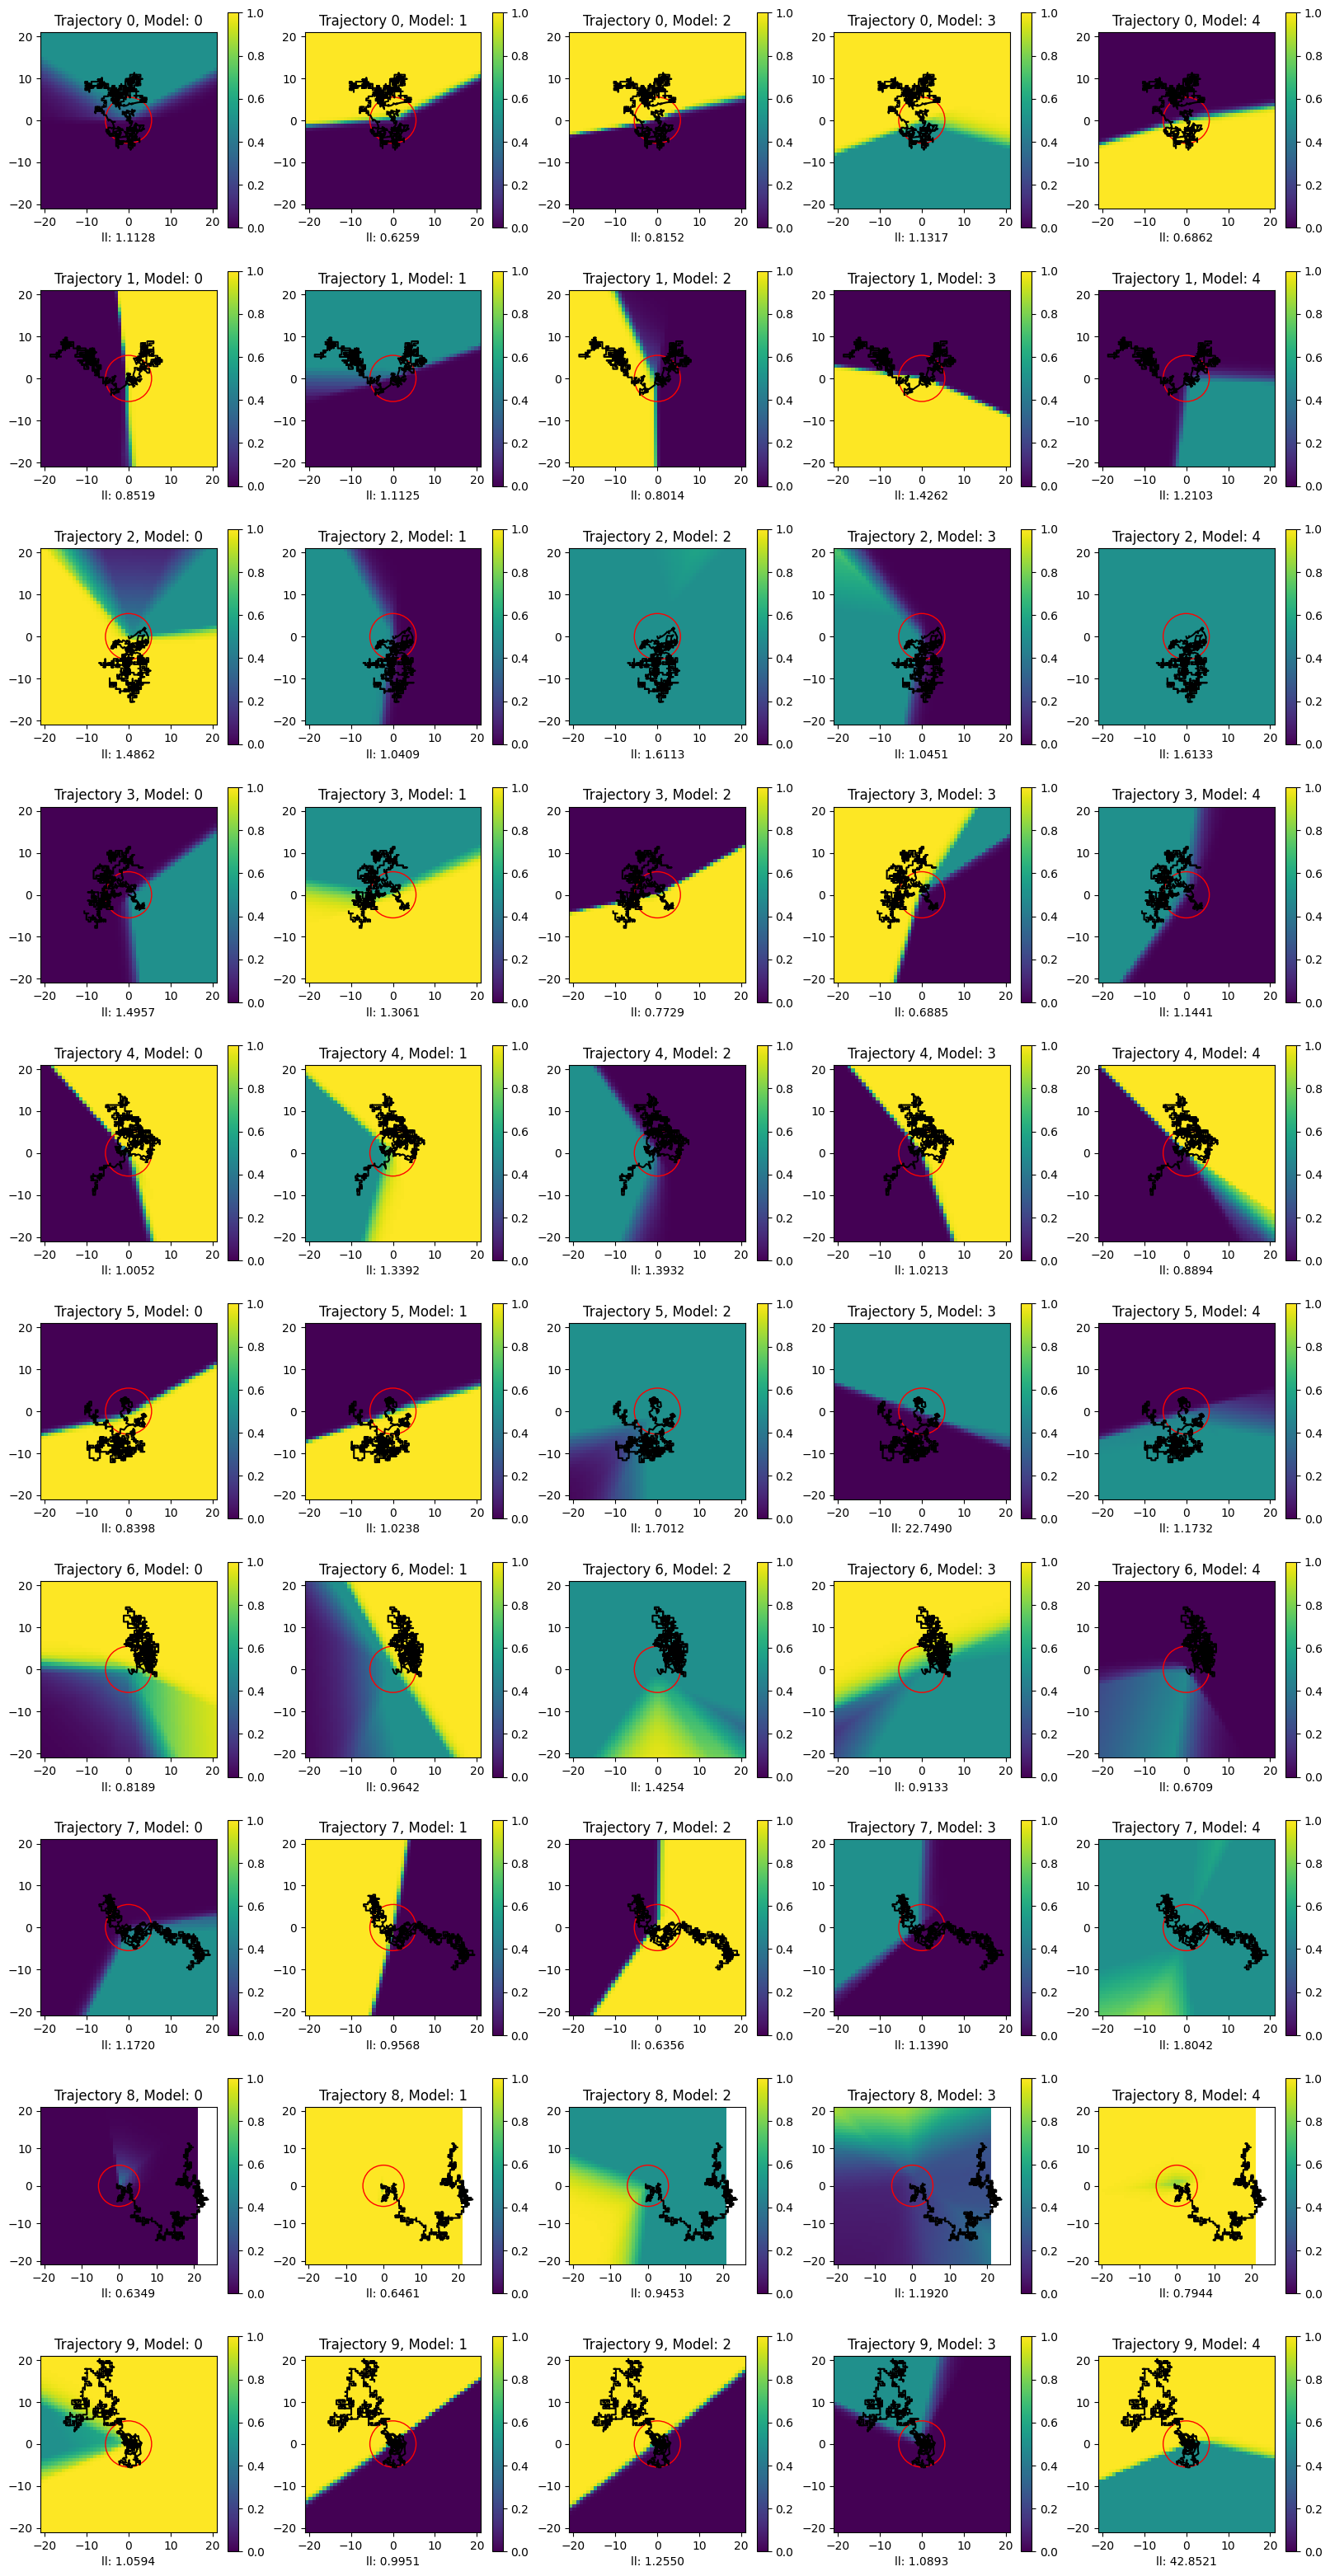

In [35]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_test(data, t=None, n=None):
    if t is None:
        ts = range(len(models))
    else:
        ts = [t]

    if n is None:
        ms = range(len(models[ts[0]]))
    else:
        ms = [n]

    # fig = plt.figure(1, figsize=(5, 5*len(ms)))
    fig, axs = plt.subplots(len(ts), len(ms), figsize=(4*len(ms), (4*len(ts))))
    if len(ts)==1:
        axs = [axs]
    if len(ms)==1:
        axs = [[a] for a in axs]

    
    size = 20
    res = 50
    lin = np.linspace(-size, size, res).reshape(-1,1)
    X,Y = np.meshgrid(lin, lin)

    d = np.stack((X, Y), axis=-1).reshape(-1, 2)
    d = torch.from_numpy(d).type(torch.DoubleTensor)
    
    for row, t in zip(axs, ts):
        df_s = pd.DataFrame(data[data.n==t].s.to_list(), columns=['x','y'])
        
        for ax, m in zip(row, ms):
            ax.set_title(f'Trajectory {t}, Model: {m}')
            corr = models[t][m][0](d)[:,1].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
            with torch.no_grad():
                p = ax.imshow(corr, extent=(int(min(lin))-1, int(max(lin))+1, int(max(lin))+1, int(min(lin))-1), vmin = 0, vmax = 1)
                plt.colorbar(p)
            ax.invert_yaxis()
            ax.set_xlabel(f'll: {results[t][m][-1]:.4f})
            ax.plot(df_s.x, df_s.y, color='black')
            ax.add_patch(Circle((0, 0), theta[0]+force, edgecolor='red', fill=False))



plot_test(df)
# plot_test(df, 0)
# plot_test(df, 0,0)

In [36]:
df_results = pd.DataFrame({
    "n": [i for i,values in enumerate(results) for _ in values],
    "nn": [j for _,values in enumerate(results) for j,_ in enumerate(values)],
    # "ll": [v.item() for values in results for v in values],
    "ll": [v[-1] for values in results for v in values],
    "ll_ideal": [loglike(
            torch.from_numpy(np.stack((1-df.loc[df.n==i].iloc[:-1].m.to_numpy(), df.loc[df.n==i].iloc[:-1].m.to_numpy()), axis=-1)),
            df.loc[df.n==i]
        ).item() for i,values in enumerate(results) for j,v in enumerate(values)],
    "ll_const": [loglike(
            # torch.from_numpy(np.stack((np.ones(df[df.n==i].shape[0]-1), np.zeros(df[df.n==i].shape[0]-1)), axis=-1)).type(torch.DoubleTensor),
            torch.from_numpy(np.stack((np.zeros(df[df.n==i].shape[0]-1), np.ones(df[df.n==i].shape[0]-1)), axis=-1)).type(torch.DoubleTensor),
            df.loc[df.n==i]
        ).item() for i,values in enumerate(results) for _,_ in enumerate(values)],
})

df_results.head(10)

TypeError: loglike() missing 1 required positional argument: 'data'

In [37]:
df_agg = df_results[['n', 'll']].groupby('n').agg(['mean', 'median', 'std', 'min', 'max'])
df_agg

NameError: name 'df_results' is not defined

In [38]:
df_results[df_results.n==5]

NameError: name 'df_results' is not defined

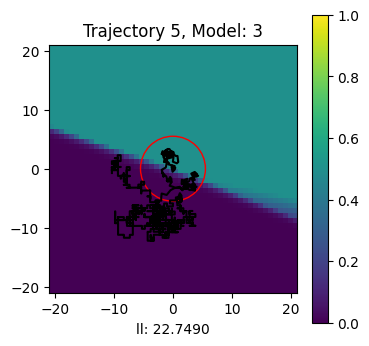

In [39]:
plot_test(df, 5,3)

In [40]:
df_results['dist'] = df_results.ll-df_results.ll_ideal
df_results[['dist', 'n']].groupby('n').agg(['mean', 'median', 'std', 'min', 'max'])

NameError: name 'df_results' is not defined

In [41]:
df_results['relativ'] = df_results.ll/df_results.ll_ideal
df_results[['relativ', 'n']].groupby('n').agg(['mean', 'median', 'std', 'min', 'max'])

NameError: name 'df_results' is not defined